# Imports

In [1]:
from collections import defaultdict
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import argmax, array, log
from numpy.random import rand, randn, choice
from tqdm import trange

# Helpers

In [2]:
def get_samples_from_normal_dist(n_samples_=10, mu=0, variance=1):
    return (sqrt(variance)*randn(n_samples_))+mu

# Bandit

In [3]:
class Bandit:
    def __init__(self, no_arms, reward_var = 1):
        self.no_arms = no_arms
        self.reward_var = reward_var
        # Initialises arm-means with normal distribution
        self.q_stars = get_samples_from_normal_dist(no_arms)
        self.best_arm = argmax(self.q_stars)
    def get_best_arm(self):
        return self.best_arm
    def get_rewards(self, arm, no_samples=1):
        # Returns rewards from normal distribution with
        # mean = arm_mean and variance = reward_var
        return get_samples_from_normal_dist(no_samples, mu=self.q_stars[arm], variance=self.reward_var)
    def plot(self, no_samples=2000, save_path=None):
        reward_set = []
        for arm_idx in range(self.no_arms):
            reward_set.append(self.get_rewards(arm_idx,no_samples))
        plt.figure(figsize=(15, 8))
        plt.violinplot(dataset=reward_set,showmeans=True)
        plt.xticks(list(range(1,self.no_arms+1)),list(range(self.no_arms)))
        plt.xlabel("Arm")
        plt.ylabel("Reward distribution")
        plt.show()
        if save_path:
            plt.savefig(save_path)
        plt.close()

# Algorithms

In [4]:
class EGreedy(Bandit):
    def __init__(self, no_arms, reward_var = 1, epsilon_=0):
        super(EGreedy,self).__init__(no_arms, reward_var)
        self.epsilon = epsilon_
        self.current_best_arm = (-1, 0)
        self.q_arms = defaultdict(float)
        self.arms_count = defaultdict(int)
        self.time = 0
        
    def pick_best_arm(self):
        pick_determiner = rand()
        if pick_determiner<self.epsilon or (self.current_best_arm[0]==-1):
            return choice(self.no_arms)
        return self.current_best_arm[0]
    
    def update_current_best_arm(self, arm):
        if self.current_best_arm[0] == arm or (self.current_best_arm[1]< self.q_arms[arm]):
            self.current_best_arm = (arm, self.q_arms[arm])
    
    def update_values(self, arm, reward):
        # Update self.arms_count
        self.arms_count[arm] += 1
        # Update q_arms
        self.q_arms[arm] += (reward - self.q_arms[arm]) / self.arms_count[arm]
        # Update self.current_best_arm
        self.update_current_best_arm(arm)
        
    def run(self, time_instances=1000):
        rewards_obtained = []
        is_opt_action = []
        arms_pulled = []
        while self.time < time_instances:
            self.time += 1
            chosen_arm = self.pick_best_arm()
            reward = self.get_rewards(chosen_arm)[0]
            rewards_obtained.append(reward)
            is_opt_action.append(1 if chosen_arm==self.best_arm else 0)
            self.update_values(chosen_arm, reward)
        return rewards_obtained, is_opt_action 

In [5]:
class UCB(EGreedy):
    def __init__(self, no_arms, reward_var = 1, epsilon_=0, ucb_confidence_ = 0.1):
        super(UCB,self).__init__(no_arms, reward_var, epsilon_)
        self.ucb_confidence = ucb_confidence_
        
    def update_current_best_arm(self, arm):
        ucb_estimations = []
        for arm_ in range(self.no_arms):
            ucb_estimations.append(self.q_arms[arm_] + \
            self.ucb_confidence * sqrt(log(self.time + 1) / (self.arms_count[arm_] + 1e-5)))
        current_max_arm = argmax(ucb_estimations)
        self.current_best_arm = (current_max_arm,)

# Experiment

In [6]:
class Experiment:
    def __init__(self, no_arms, time_instances, no_runs,
                 reward_variance_list, epsilon_list, ucb_conf_list,
                 plot_save_path):
        self.no_arms = no_arms
        self.time_instances = time_instances
        self.no_runs = no_runs
        self.reward_variance_list = reward_variance_list
        self.epsilon_list = epsilon_list
        self.ucb_conf_list = ucb_conf_list
        self.plot_save_path = plot_save_path
       
    @staticmethod
    def add_plots(data, legend_label, y_label, title_):
        plt.plot(data, label=legend_label)
        plt.title(title_)
        plt.xlabel('steps')
        plt.ylabel(y_label)
        plt.legend() 
        
    def simulate_single_exp(self, reward_var = 1, epsilon=0, ucb_confidence=None):
        avg_rewards_coll = []
        rewards_coll = []
        is_opt_coll = []
        for _ in trange(self.no_runs):
            if ucb_confidence:
                selected_bandit = UCB(self.no_arms, reward_var, epsilon_=epsilon, ucb_confidence_= ucb_confidence)
            else:
                selected_bandit = EGreedy(self.no_arms, reward_var, epsilon_=epsilon)
            rewards, is_opt = selected_bandit.run(self.time_instances)
            rewards_coll.append(rewards)
            is_opt_coll.append(is_opt)
        return array(rewards_coll).mean(axis=0), array(is_opt_coll).mean(axis=0)*100
    
    def run(self):
        for reward_variance in self.reward_variance_list:
            print("===============================================")
            
            # -------------- Simulating --------------
            print(f"Simultion for Reward Variance:{reward_variance}")
            average_reward_collection = []
            optimal_action_collection = []
            for eps in self.epsilon_list:
                print(f"Simulating for epsilon {eps}")
                rew_coll, per_opt_coll = self.simulate_single_exp(reward_var=reward_variance,
                                                                  epsilon=eps)
                average_reward_collection.append((rew_coll,'epsilon = %.02f' % (eps)))
                optimal_action_collection.append((per_opt_coll,'epsilon = %.02f' % (eps)))
            for ucb_conf in self.ucb_conf_list:
                print(f"Simulating for UCB confidence {ucb_conf}")
                rew_coll, per_opt_coll = self.simulate_single_exp(reward_var=reward_variance,
                                                                  epsilon=0,
                                                                  ucb_confidence=ucb_conf)
                average_reward_collection.append((rew_coll,'UCB = %.02f' % (ucb_conf)))
                optimal_action_collection.append((per_opt_coll,'UCB = %.02f' % (ucb_conf)))
                
            # -------------- Plotting --------------
            plt.figure(figsize=(10, 20))
            plt.subplot(2, 1, 1)
            for rewards, legend_label in average_reward_collection:
                self.add_plots(rewards,legend_label,'average reward', "Awerage Reward vs Steps")
            plt.subplot(2, 1, 2)
            for counts, legend_label in optimal_action_collection:
                self.add_plots(counts,legend_label,'% optimal action', "Optimal Action Percentage vs Steps")
            plt.show()
            if self.plot_save_path:
                plt.savefig(self.plot_save_path.format(f"variance_{reward_variance}"))
            plt.close()
            print("===============================================")

# Simulations and plots

### Bandit with reward-variance = 1

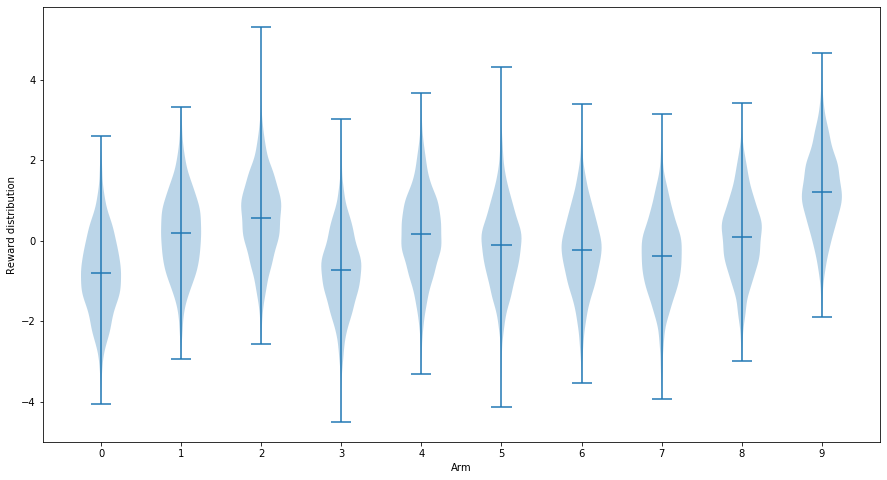

Optimal Arm is 9


In [7]:
bandit_var1 = Bandit(10)
bandit_var1.plot()
print(f"Optimal Arm is {bandit_var1.get_best_arm()}")

### Bandit with reward-variance = 10

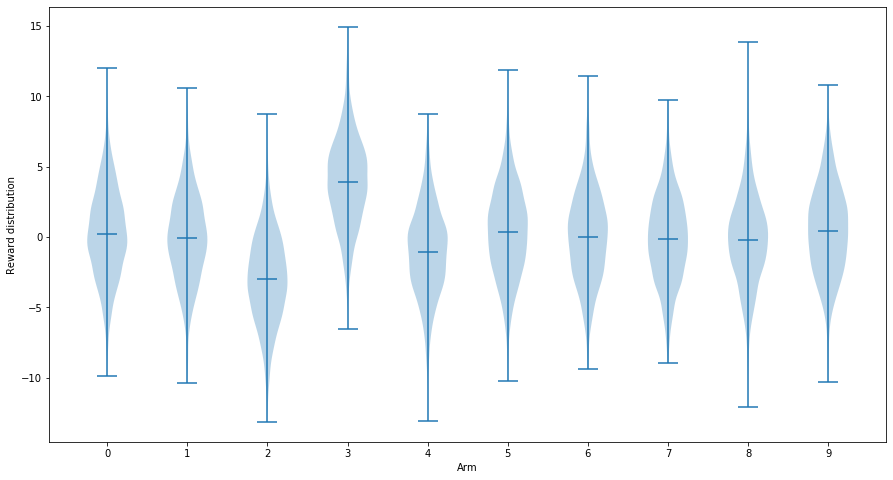

Optimal Arm is 3


In [8]:
bandit_var10 = Bandit(10, reward_var=10)
bandit_var10.plot()
print(f"Optimal Arm is {bandit_var10.get_best_arm()}")

### Average reward and % optimal action plots for multiple variances

In [9]:
experiment = Experiment(no_arms=10, time_instances=1000, no_runs=2000,
                        reward_variance_list= [1,10],
                        epsilon_list=[0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9],
                        ucb_conf_list=[0.1, 0.5, 1, 2, 3, 5, 10],
                        plot_save_path="10_arms_bandit_{}.png")

  1%|          | 16/2000 [00:00<00:12, 158.19it/s]

Simultion for Reward Variance:1
Simulating for epsilon 0


  1%|          | 18/2000 [00:00<00:11, 170.10it/s]

Simulating for epsilon 0.01


  1%|          | 17/2000 [00:00<00:12, 164.85it/s]

Simulating for epsilon 0.05


  1%|          | 16/2000 [00:00<00:12, 153.26it/s]

Simulating for epsilon 0.1


  1%|          | 15/2000 [00:00<00:13, 148.92it/s]

Simulating for epsilon 0.2


  1%|          | 15/2000 [00:00<00:14, 141.36it/s]

Simulating for epsilon 0.3


  1%|          | 14/2000 [00:00<00:15, 131.09it/s]

Simulating for epsilon 0.5


  1%|          | 12/2000 [00:00<00:16, 117.39it/s]

Simulating for epsilon 0.9


  0%|          | 4/2000 [00:00<01:00, 32.77it/s]

Simulating for UCB confidence 0.1


  0%|          | 3/2000 [00:00<01:24, 23.62it/s]

Simulating for UCB confidence 0.5


  0%|          | 4/2000 [00:00<01:05, 30.36it/s]

Simulating for UCB confidence 1


  0%|          | 4/2000 [00:00<01:03, 31.19it/s]

Simulating for UCB confidence 2


  0%|          | 3/2000 [00:00<01:09, 28.65it/s]

Simulating for UCB confidence 3


  0%|          | 4/2000 [00:00<00:57, 34.47it/s]

Simulating for UCB confidence 5


  0%|          | 4/2000 [00:00<00:56, 35.51it/s]

Simulating for UCB confidence 10


100%|██████████| 2000/2000 [01:00<00:00, 32.90it/s]


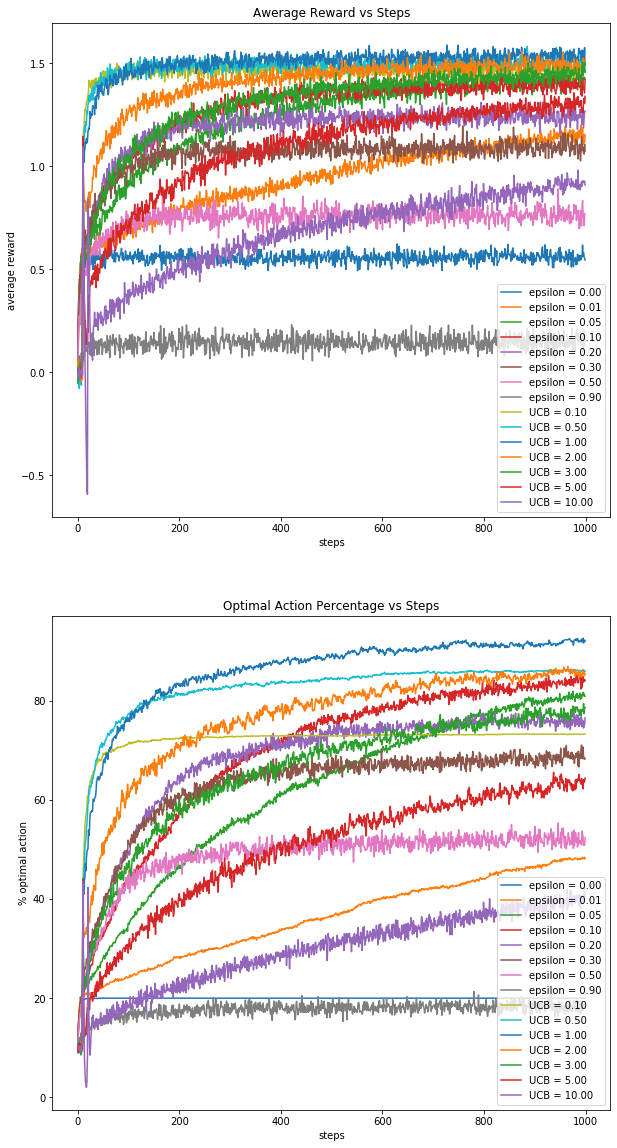

  1%|          | 17/2000 [00:00<00:11, 167.67it/s]

Simultion for Reward Variance:10
Simulating for epsilon 0


  1%|          | 17/2000 [00:00<00:12, 164.52it/s]

Simulating for epsilon 0.01


  1%|          | 16/2000 [00:00<00:12, 159.09it/s]

Simulating for epsilon 0.05


  1%|          | 17/2000 [00:00<00:11, 166.15it/s]

Simulating for epsilon 0.1


  2%|▏         | 32/2000 [00:00<00:12, 157.77it/s]

Simulating for epsilon 0.2


  1%|          | 15/2000 [00:00<00:13, 143.56it/s]

Simulating for epsilon 0.3


  1%|▏         | 29/2000 [00:00<00:13, 141.37it/s]

Simulating for epsilon 0.5


  1%|          | 12/2000 [00:00<00:16, 118.11it/s]

Simulating for epsilon 0.9


  0%|          | 4/2000 [00:00<00:55, 35.87it/s]

Simulating for UCB confidence 0.1


  0%|          | 4/2000 [00:00<00:56, 35.11it/s]

Simulating for UCB confidence 0.5


  0%|          | 4/2000 [00:00<01:03, 31.59it/s]

Simulating for UCB confidence 1


  0%|          | 7/2000 [00:00<01:04, 30.70it/s]

Simulating for UCB confidence 2


  0%|          | 4/2000 [00:00<00:58, 34.04it/s]

Simulating for UCB confidence 3


  0%|          | 4/2000 [00:00<00:57, 34.65it/s]

Simulating for UCB confidence 5


  0%|          | 4/2000 [00:00<00:59, 33.64it/s]

Simulating for UCB confidence 10


100%|██████████| 2000/2000 [01:01<00:00, 32.31it/s]


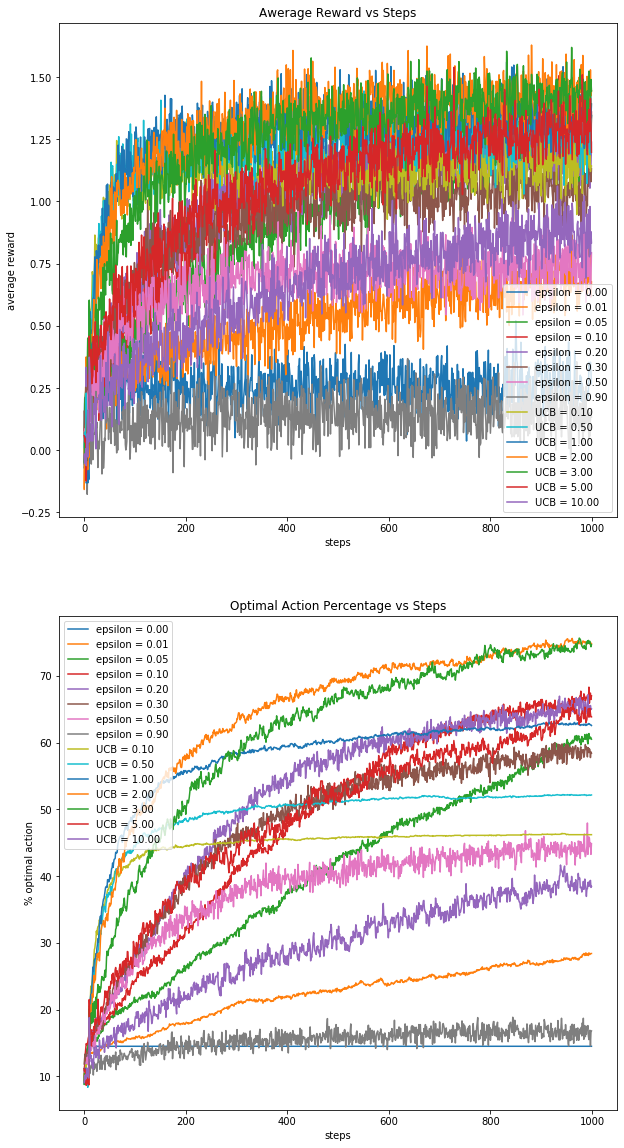

In [10]:
experiment.run()

### Study and Inferences

#### 1. Comparison between different epsilon values

  2%|▏         | 31/2000 [00:00<00:13, 146.11it/s]

Simultion for Reward Variance:1
Simulating for epsilon 0


  1%|          | 16/2000 [00:00<00:12, 156.03it/s]

Simulating for epsilon 0.01


  1%|          | 16/2000 [00:00<00:12, 156.84it/s]

Simulating for epsilon 0.05


  2%|▏         | 33/2000 [00:00<00:12, 161.60it/s]

Simulating for epsilon 0.1


  1%|          | 14/2000 [00:00<00:14, 136.31it/s]

Simulating for epsilon 0.2


  1%|          | 14/2000 [00:00<00:14, 138.39it/s]

Simulating for epsilon 0.3


  1%|          | 12/2000 [00:00<00:16, 118.76it/s]

Simulating for epsilon 0.5


  1%|          | 12/2000 [00:00<00:17, 113.55it/s]

Simulating for epsilon 0.9


100%|██████████| 2000/2000 [00:17<00:00, 116.85it/s]


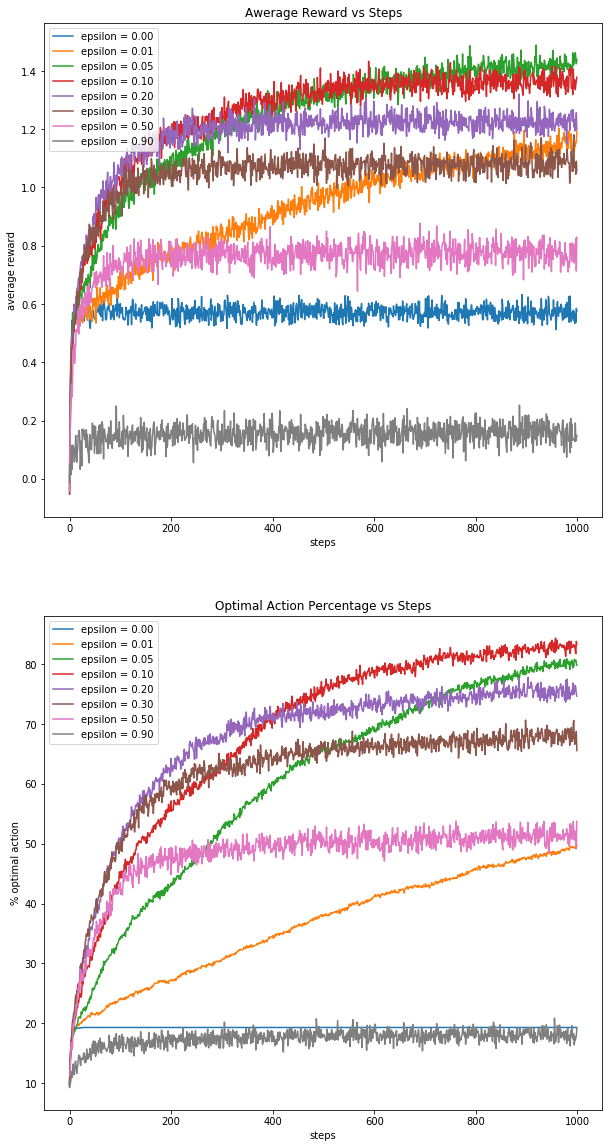

In [14]:
experiment = Experiment(no_arms=10, time_instances=1000, no_runs=2000,
                        reward_variance_list= [1],
                        epsilon_list=[0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9],
                        ucb_conf_list=[],
                        plot_save_path=None)
experiment.run()

#### 2. Comparison between different UCB confidence values

  0%|          | 3/2000 [00:00<01:06, 29.81it/s]

Simultion for Reward Variance:1
Simulating for UCB confidence 0.1


  0%|          | 4/2000 [00:00<01:00, 32.77it/s]

Simulating for UCB confidence 0.5


  0%|          | 4/2000 [00:00<00:59, 33.34it/s]

Simulating for UCB confidence 1


  0%|          | 4/2000 [00:00<00:57, 34.84it/s]

Simulating for UCB confidence 2


  0%|          | 4/2000 [00:00<01:01, 32.44it/s]

Simulating for UCB confidence 3


  0%|          | 4/2000 [00:00<01:04, 30.71it/s]

Simulating for UCB confidence 5


  0%|          | 4/2000 [00:00<01:03, 31.67it/s]

Simulating for UCB confidence 10


100%|██████████| 2000/2000 [01:07<00:00, 29.74it/s]


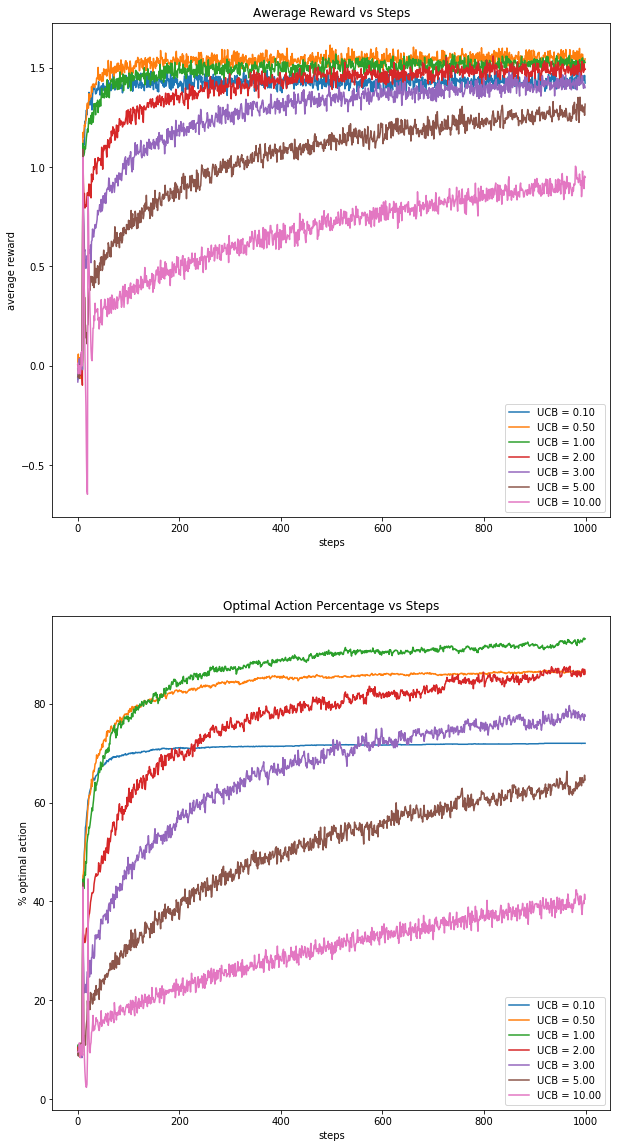

In [15]:
experiment = Experiment(no_arms=10, time_instances=1000, no_runs=2000,
                        reward_variance_list= [1],
                        epsilon_list=[],
                        ucb_conf_list=[0.1, 0.5, 1, 2, 3, 5, 10],
                        plot_save_path=None)
experiment.run()

#### 3. Comparison between E-Greedy and UCB 

  1%|          | 15/2000 [00:00<00:13, 143.00it/s]

Simultion for Reward Variance:1
Simulating for epsilon 0


  0%|          | 4/2000 [00:00<00:56, 35.42it/s]

Simulating for UCB confidence 2


100%|██████████| 2000/2000 [01:04<00:00, 30.90it/s]


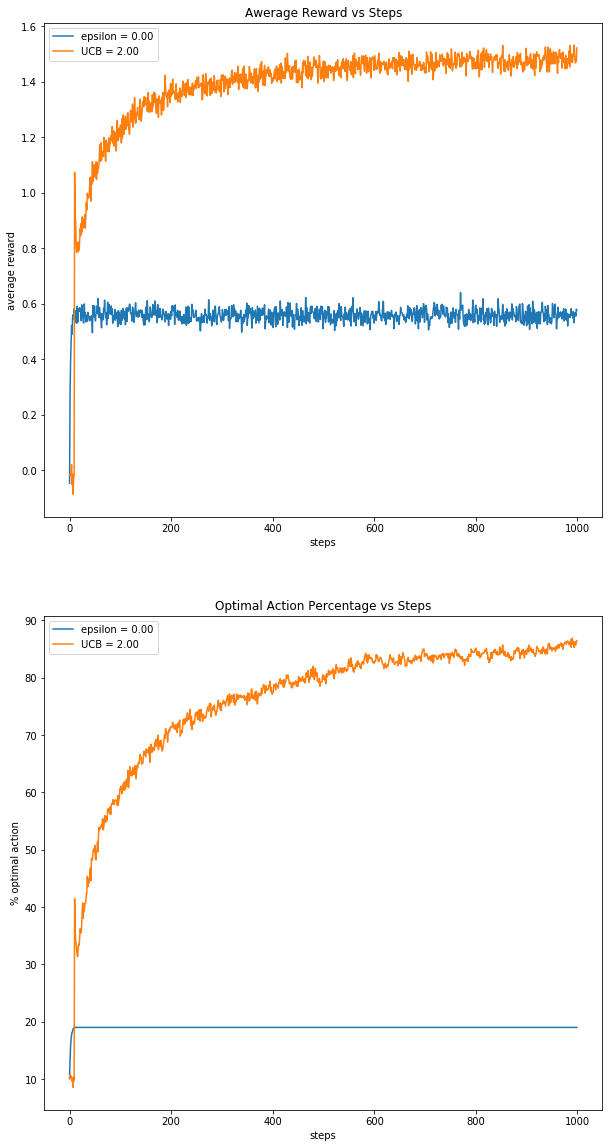

In [16]:
experiment = Experiment(no_arms=10, time_instances=1000, no_runs=2000,
                        reward_variance_list= [1],
                        epsilon_list=[0],
                        ucb_conf_list=[2],
                        plot_save_path=None)
experiment.run()

#### 4. Comparison between different reward-variance

  1%|          | 14/2000 [00:00<00:14, 138.77it/s]

Simultion for Reward Variance:1
Simulating for epsilon 0


100%|██████████| 2000/2000 [00:11<00:00, 171.15it/s]


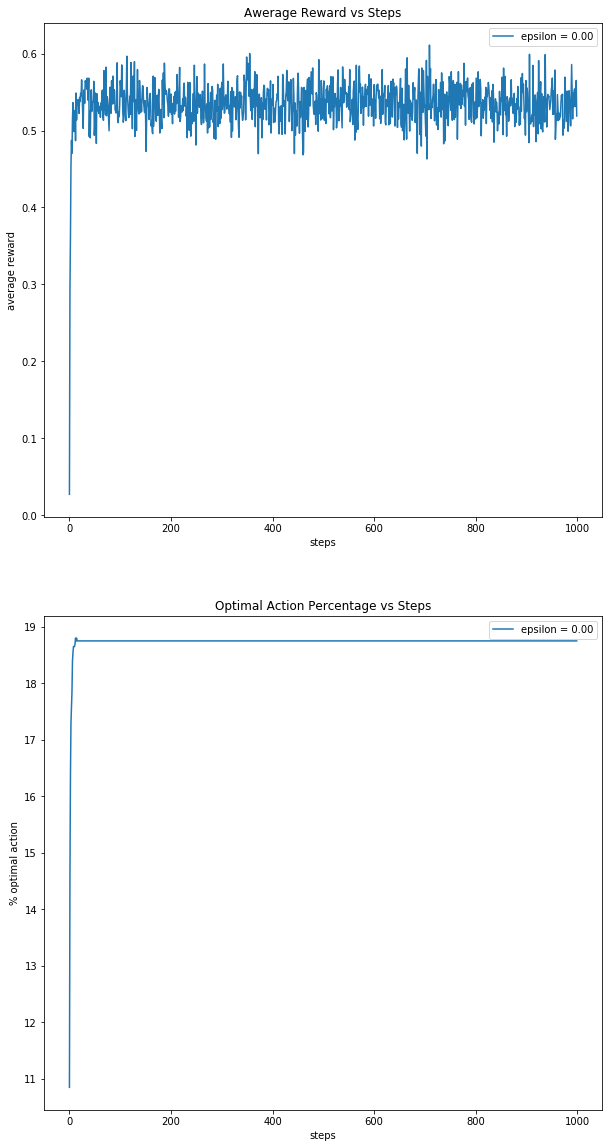

  1%|          | 17/2000 [00:00<00:11, 167.73it/s]

Simultion for Reward Variance:10
Simulating for epsilon 0


100%|██████████| 2000/2000 [00:11<00:00, 168.54it/s]


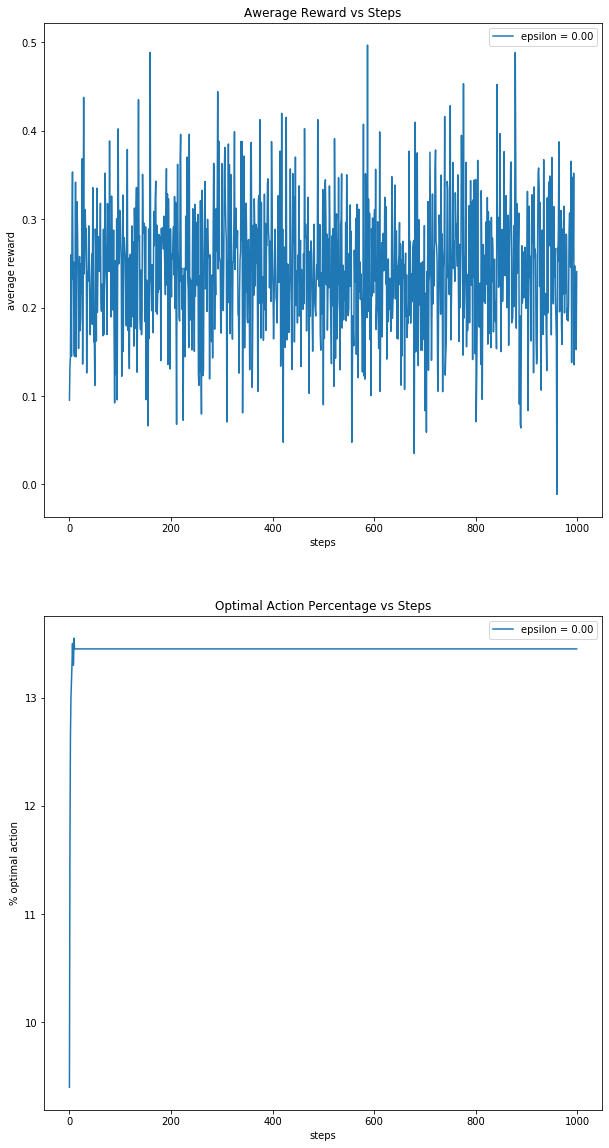

In [17]:
experiment = Experiment(no_arms=10, time_instances=1000, no_runs=2000,
                        reward_variance_list= [1,10],
                        epsilon_list=[0],
                        ucb_conf_list=[],
                        plot_save_path=None)
experiment.run()